In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
import matplotlib.pyplot as plt
import numpy as np
import time

from UpperLevel.L1norm import *
from UpperLevel.hessians import *


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
u0 = get_sample_data('2d-mri')
u0_mat = (1+0j)*u0.data[125:155,125:155]

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(u0_mat)+5e-7*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [3]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1]=1e-6
p = np.copy(radial_p)

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

In [4]:
eps=1e-6
gamma=1e-10

# Checking gradients

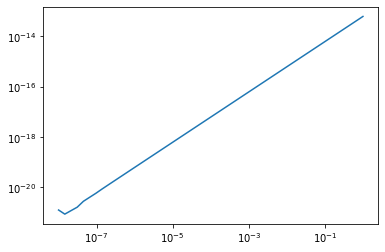

In [5]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-8,0,50)
real_values = np.array([Eeps(a+t*a2,radial_p,eps=eps) for t in tests])
approx = np.array([Eeps(a,radial_p,eps=eps)+t*np.sum(np.real(Du_Eeps(a,radial_p,eps=eps))*np.real(a2)+
                                          np.imag(Du_Eeps(a,radial_p,eps=eps))*np.imag(a2)) for t in tests])

plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

8.332952468600995e-08


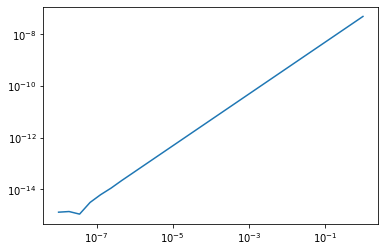

In [6]:
# -- Edata --
#Random vector with same amplitude as u0
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

p=radial_p
tests = np.logspace(-8,0,30)
real_values = np.array([Edata(a+t*a2,p,fourier_op = fourier_op,y = y) for t in tests])
approx = np.array([Edata(a,p,fourier_op = fourier_op,y = y)+
                   np.sum(np.real(Du_Edata(a,radial_p,fourier_op = fourier_op,y = y))*np.real(t*a2)+
                            np.imag(Du_Edata(a,radial_p,fourier_op = fourier_op,y = y))*np.imag(t*a2))
                   for t in tests])

print(Edata(a,radial_p,fourier_op = fourier_op,y = y))
plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

9.555578524111413e-09


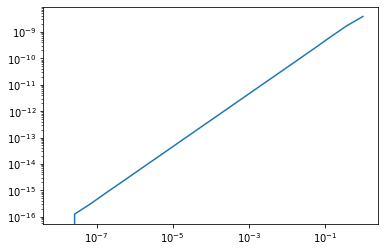

In [7]:
# -- Ereg --
#Random vector with same amplitude as u0
a = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-8,0,20)
real_values = np.array([Ereg(a+t*a2,radial_p,linear_op = linear_op,gamma=gamma) for t in tests])
approx = np.array([Ereg(a,radial_p,linear_op = linear_op,gamma=gamma)+
                   t*np.sum(np.real(Du_Ereg(a,radial_p,linear_op = linear_op,gamma=gamma))*np.real(a2)+
                            np.imag(Du_Ereg(a,radial_p,linear_op = linear_op,gamma=gamma))*np.imag(a2))
                   for t in tests])

print(Ereg(a,radial_p,linear_op = linear_op,gamma=gamma))
plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

8.984310554424317e-08


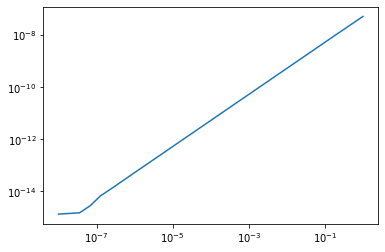

In [8]:
# -- Etot --
#Random vector with same amplitude as u0
a = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-8,0,30)
real_values = np.array([Etot(a+t*a2,radial_p,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma) for t in tests])
approx = np.array([Etot(a,radial_p,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma)+
                   t*np.sum(np.real(Du_Etot(a,radial_p,eps=eps,fourier_op=fourier_op,y=y,
                                            linear_op=linear_op,gamma=gamma))*np.real(a2)+
                            np.imag(Du_Etot(a,radial_p,eps=eps,fourier_op=fourier_op,y=y,
                                            linear_op=linear_op,gamma=gamma))*np.imag(a2))
                   for t in tests])

print(Etot(a,radial_p,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma))
plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

# Checking hessians

3.4976247470205565e-10


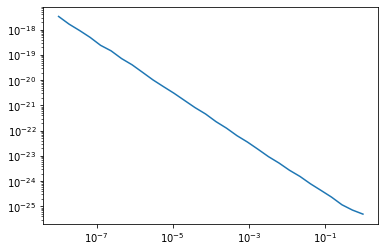

In [9]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=30
tests = np.logspace(-8,0,ntest)
Dua = Du_Eeps(a,p,eps=eps)
real = []
approx = []
for t in tests:
    real.append(Du_Eeps(a+t*a2,p,eps=eps))
    approx.append(Dua+Du2_Eeps(a,p,t*a2,eps=eps))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

0.00041103237336019446


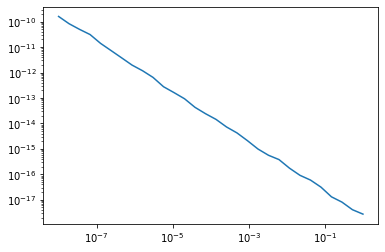

In [10]:
# -- Edata --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=30
tests = np.logspace(-8,0,ntest)
real = []
approx = []
Dua = Du_Edata(a,radial_p,fourier_op=fourier_op,y=y)
for t in tests:
    real.append(Du_Edata(a+t*a2,radial_p,fourier_op=fourier_op,y=y))
    approx.append(Dua+Du2_Edata(a,radial_p,t*a2,fourier_op=fourier_op,y=y))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

2.9999999999997724e-05


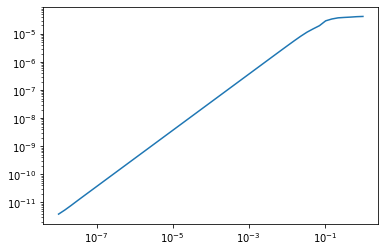

In [11]:
# -- Ereg --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=50
tests = np.logspace(-8,0,ntest)
real = []
approx = []
Dua = Du_Ereg(a,radial_p,linear_op=linear_op,gamma=gamma)
for t in tests:
    real.append(Du_Ereg(a+t*a2,radial_p,linear_op=linear_op,gamma=gamma))
    approx.append(Dua+Du2_Ereg(a,radial_p,t*a2,linear_op=linear_op,gamma=gamma))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

0.0004143521157515805


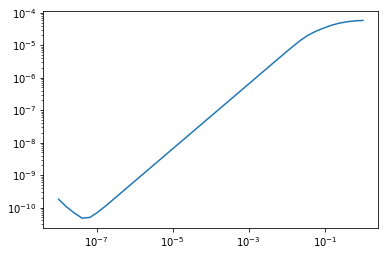

In [12]:
# -- Etot --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=40
tests = np.logspace(-8,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Etot(a+t*a2,p,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma))
    approx.append(Du_Etot(a,p,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma)+
                  t*Du2_Etot(a,p,a2,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma))

print(np.linalg.norm(Du_Etot(a,p,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma)))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

# Checking if symetric positive definite

In [28]:
# Compute the matrix
mat = np.zeros((2*n**2,2*n**2))
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

for i in range(n**2):
    vec = np.zeros((n,n))
    vec[i//n,i%n]=1
    
    fx = Du2_Edata(a,p,vec,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma)    
    result = np.reshape(fx,(1,n**2))
    mat[i,:n**2] = np.real(result)
    mat[i,n**2:] = np.imag(result)
    mat[n**2+i,:n**2] = -np.imag(result)
    mat[n**2+i,n**2:] = np.real(result)

In [29]:
#Checking if symmetric by comparing mat and mat.transpose()
print(np.mean(np.absolute(mat)),np.mean(np.absolute(mat-mat.transpose())))
print(np.allclose(mat,mat.transpose(),atol=1e-10*np.mean(np.absolute(mat)),rtol=1e-10))

0.004859018621606857 4.1047813912195807e-17
True


In [30]:
# Computing <x,Ax> for base vectors to see if positive
xAx = np.zeros(2*n**2)
for i in range(2*n**2):
    xtest = np.zeros((2*n**2,1))
    xtest[i]=1
    xAx[i] = np.sum(xtest*np.dot(mat,xtest))

In [31]:
print(np.all(np.array(xAx)>0))

True


## Check with complex version directly

In [61]:
# Compute the matrix
mat = (1+1j)*np.zeros((n**2,n**2))
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

for i in range(n**2):
    vec = (1+1j)*np.zeros((n,n))
    vec[i//n,i%n]=1+0j
    
    fx = Du2_J(a,vec,eps=eps,fourier_op=fourier_op,y=y,linear_op=linear_op,gamma=gamma)    
    mat[i,:] = np.reshape(fx,(1,n**2))

In [62]:
print(np.allclose(mat,np.asmatrix(mat).H,atol=1e-10*np.mean(np.absolute(mat)),rtol=1e-10))

False


In [63]:
print(np.allclose(mat,mat.transpose(),atol=1e-10*np.mean(np.absolute(mat)),rtol=1e-10))

True
